In [303]:
!pip install numpy python-dotenv dwave-ocean-sdk openjij pyqubo matplotlib scikit-learn pandas

In [304]:
import numpy as np
from dotenv import load_dotenv
from dwave.system import DWaveSampler, EmbeddingComposite
from numpy import hamming
from openjij import SQASampler
import openjij
from pyqubo import Array, Constraint, LogEncInteger, solve_qubo
import math
import os
import dimod
from minorminer import find_embedding
from dwave.system import FixedEmbeddingComposite
from dwave.embedding import embed_bqm
from dwave.embedding import MinimizeEnergy
from matplotlib import pyplot as plt
import sklearn
import itertools
from copy import copy, deepcopy
import pandas as pd
from load_dataset import load_knapsack

# 量子アニーリング

## データセット

In [305]:
load_dotenv()

TOKEN = os.getenv("TOKEN")
endpoint = "https://cloud.dwavesys.com/sapi/"
solver = "QA"
num_reads = 1000

In [306]:
dataset = load_knapsack(
    "../dataset/knapsack/instances_01_KP/low-dimensional/f4_l-d_kp_4_11")[0]
W = dataset.capacity
N = dataset.n
cost_list = dataset.cost_list
weight_list = dataset.weight_list
opt = dataset.optimum_state
opt_value = np.dot(dataset.optimum_state, cost_list)
print("W:", W)
print("N:", N)
print("opt:", dataset.optimum_value)
print("   :", opt_value)


W: 11
N: 4
opt: 23.0
   : 0.0


In [307]:
x = Array.create('x', shape=(N), vartype='BINARY')
y = LogEncInteger("y", (0, W))

In [308]:
print("len x: {}".format(len(x)))
print("len y: {}".format(len(y.array)))

len x: 4
len y: 4


In [309]:
print(f"& {N} & {W} &  {len(y.array)} &  {N + len(y.array)} & {dataset.optimum_value} \\\\")

& 4 & 11 &  4 &  8 & 23.0 \\


In [310]:
# key1 = max(cost_list, key=lambda k: cost_list[k])
max_c = max(cost_list)
B = 1
A = B * max_c * 2

In [311]:
HA = Constraint(
    A * (W - sum(weight_list[a] * x[a] for a in range(N)) - y)**2, label='HA'
)

HB = - B * sum(cost_list[a] * x[a] for a in range(N))

In [312]:
H = HA + HB
model = H.compile()
Q, offset = model.to_qubo()

In [313]:
if solver == "QA":
    dw_sampler = DWaveSampler(solver='Advantage_system6.1',
                            token=TOKEN, endpoint=endpoint)
    adj = {}
    for k in Q.keys():
        adj[k] = 1
    embedding = find_embedding(adj, dw_sampler.edgelist)
    # bqm_embed = embed_bqm(bqm, embedding, dw_sampler.adjacency)
    sampler = FixedEmbeddingComposite(dw_sampler, embedding)
    # sampler = EmbeddingComposite(dw_sampler)
    # sampleset_embed = dw_sampler.sample(bqm_embed, num_reads=10)
    print("setting DW sampler")
else:
    sampler = SQASampler(num_reads=num_reads)
    print("setting SQA sampler")

setting DW sampler


## フォワードアニーリング

In [314]:
# t = [(0, 20), (0, 5, 15, 20), (0, 5, 6, 20), (0, 9, 10, 20), (0, 19, 20)]
# s = [(0, 1), (0, 0.5, 0.5, 1), (0, 0.5, 1, 1), (0, 0.5, 1, 1), (0, 0.5, 1)]
t = [(0, 100)]
s = [(0, 1)]

schedules = [list(zip(t[i], s[i])) for i in range(len(t))]
print(schedules)


[[(0, 0), (100, 1)]]


In [315]:
def plot_schedules(t, s, save_path="output.jpg", title=None):
    linestyle = ["solid", "dotted", "dashed",
                 "dashdot", (0, (1, 10)), (0, (3, 1, 1, 1))]
    if len(t) == 1:
        fig, ax = plt.subplots(1)
        fig = [fig]
        ax = [ax]
    else:
        fig, ax = plt.subplots(1, len(t))
        fig.set_figwidth(5 * len(t))

    for i in range(len(t)):
        ax[i].plot(t[i], s[i])
        ax[i].set_xlim(-1.0, t[i][-1] + 1.0)
        ax[i].set_ylim(-0.1, 1.1)
        if not title == None:
            ax[i].set_title(title[i].upper())

    plt.tight_layout()
    plt.savefig(save_path)

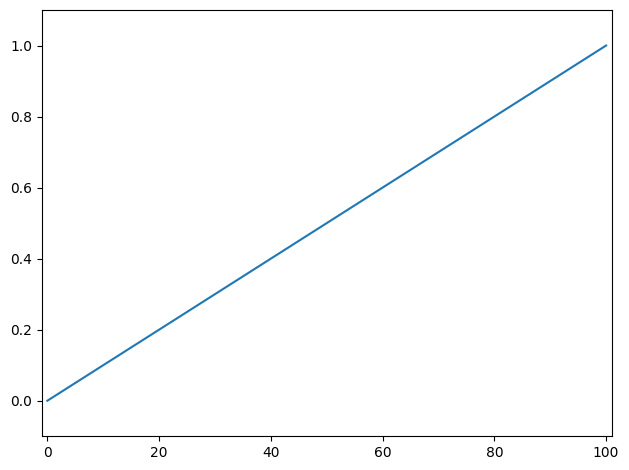

In [316]:
plot_schedules(t, s, "anneal_schedule.jpg")

In [317]:
samplesets = []
for schedule in schedules:
    print("annealing start")
    if solver == "QA":
        samplesets.append(sampler.sample_qubo(
            Q, num_reads=num_reads, anneal_schedule=schedule))
    else:
        samplesets.append(sampler.sample_qubo(Q))
    print("annealing end")

annealing start
annealing end


In [318]:
def dict_from_sampleview(sampleview):
    d = {}

    for key in sampleview.keys():
        d[key] = sampleview.get(key)
    
    return d

In [319]:
def transform_sample(sampleset, schedule, model):
    # decoded_samples = model.decode_sampleset(
    #     sampleset=sampleset, vartype="BINARY")
    decoded_samples = []
    for sample, record in zip(sampleset, sampleset.record):
        decoded_sample = model.decode_sample(
            dict_from_sampleview(sample), vartype="BINARY")
        decoded_samples.append((decoded_sample, record[1]))

    value_set = []
    for decoded_sample, energy in decoded_samples:
        cost = 0
        weight = 0
        for k in range(N):
            if decoded_sample.array('x', k) != 0:
                cost += cost_list[k]
                weight += weight_list[k]

        sol_y = sum(2**k * v for k, v in [(elem, decoded_sample.array('y', elem))
                                          for elem in range(math.ceil(math.log2(W)))])

        value_set.append(
            {"cost": cost, "weight": weight, "energy": energy, "sol_y": sol_y, "broken": decoded_sample.constraints(only_broken=True)})

    value_df = pd.DataFrame(value_set)
    value_df_sorted_cost = value_df[value_df["weight"] <= W].sort_values(by=[
        "cost"])
    value_max = value_df_sorted_cost.loc[value_df_sorted_cost["cost"].idxmax()]
    value_min = value_df_sorted_cost.loc[value_df_sorted_cost["cost"].idxmin()]
    value_ave = value_df_sorted_cost["cost"].mean()
    opt_count = (value_df_sorted_cost["cost"] == opt_value).sum()
    

    # value_df_sorted_by_energy = value_df.sort_values(by=["energy"])

    return {"anneal_time": sampleset.info["timing"]["qpu_anneal_time_per_sample"],
            "anneal_schedule": schedule,
            "info_sets": value_set,
            "best_value": value_max,
            "average_cost": value_ave,
            "worst_value": value_min,
            "dataframe": value_df,
            "opt_count": opt_count,
            "success_rate": opt_count / num_reads}


def v_transform_sample(samplesets, schedules, model):
    if type(samplesets) == list:
        sample_info = []
        for (sampleset, schedule) in zip(samplesets, schedules):
            sample_info.append(transform_sample(sampleset, schedule, model))
        return sample_info
    else:
        return transform_sample(transform_sample(samplesets, schedules, model))


In [320]:
def output_sample_info(sample_info):
    print("anneal time = {}".format(sample_info["anneal_time"]))
    print("anneal schedule = {}".format(sample_info["anneal_schedule"]))
    print("---- result -----")
    print("opt_count : " + str(sample_info["opt_count"]))
    print("success rate : " + str(sample_info["success_rate"]))
    print("-----------------")
    print("----- best ------")
    print("slack_Y = {}".format(sample_info["best_value"]["sol_y"]))
    print("broken: {}".format(sample_info["best_value"]["broken"]))
    print("cost : " + str(sample_info["best_value"]["cost"]))
    print("weight : " + str(sample_info["best_value"]["weight"]))
    print("-----------------")
    print("---- average -----")
    print("cost : " + str(sample_info["average_cost"]))
    print("-----------------")
    print("----- worst -----")
    print("slack_Y = {}".format(sample_info["worst_value"]["sol_y"]))
    print("broken: {}".format(sample_info["worst_value"]["broken"]))
    print("cost : " + str(sample_info["worst_value"]["cost"]))
    print("weight : " + str(sample_info["worst_value"]["weight"]))
    print("-----------------")
    print("-----describe----")
    print(sample_info["dataframe"].describe())
    print()


def v_output_sample_info(samples_info):
    if type(samples_info) == list:
        for sample_info in samples_info:
            output_sample_info(sample_info)
    else:
        output_sample_info(samples_info)


### 結果

In [321]:
samples_info = v_transform_sample(samplesets, schedules, model)
v_output_sample_info(samples_info)


anneal time = 100.0
anneal schedule = [(0, 0), (100, 1)]
---- result -----
opt_count : 7
success rate : 0.007
-----------------
----- best ------
slack_Y = 3
broken: {'HA': (False, 234.0)}
cost : 23.0
weight : 11.0
-----------------
---- average -----
cost : 13.53921568627451
-----------------
----- worst -----
slack_Y = 6
broken: {'HA': (False, 650.0)}
cost : 0.0
weight : 0.0
-----------------
-----describe----
             cost      weight       energy       sol_y
count  112.000000  112.000000   112.000000  112.000000
mean    14.830357    6.723214 -2973.723214    6.276786
std      7.233416    3.498287   212.949861    4.323016
min      0.000000    0.000000 -3169.000000    0.000000
25%     10.000000    4.000000 -3133.750000    2.750000
50%     14.500000    7.000000 -3055.000000    6.000000
75%     19.000000    9.000000 -2923.500000   10.000000
max     35.000000   17.000000 -2238.000000   15.000000



In [322]:
len(samples_info[0]["dataframe"])


112

## リバースアニーリング

### 最良値採用

In [323]:
# init = samplesets[0].samples()[int(len(samplesets[0].samples()) / 2)]
init = samplesets[0].samples()[0]

In [324]:
tau = 100

t = []
s = []

# s_inv = 0.1
# t_inv = tau * (1 - s_inv)

# t.append((0,  t_inv, tau))
# s.append((1, s_inv, 1.0))

s_inv = 0.2
t_inv = tau * (1 - s_inv)

t.append((0,  t_inv, tau))
s.append((1, s_inv, 1.0))

s_inv = 0.3
t_inv = tau * (1 - s_inv)

t.append((0,  t_inv, tau))
s.append((1, s_inv, 1.0))

s_inv = 0.4
t_inv = tau * (1 - s_inv)

t.append((0,  t_inv, tau))
s.append((1, s_inv, 1.0))

# s_inv = 0.5
# t_inv = tau * (1 - s_inv)

# t.append((0,  t_inv, tau))
# s.append((1, s_inv, 1.0))

# s_inv = 0.6
# t_inv = tau * (1 - s_inv)

# t.append((0,  t_inv, tau))
# s.append((1, s_inv, 1.0))

reverse_schedules = [list(zip(t[i], s[i])) for i in range(len(t))]
print(reverse_schedules)


[[(0, 1), (80.0, 0.2), (100, 1.0)], [(0, 1), (70.0, 0.3), (100, 1.0)], [(0, 1), (60.0, 0.4), (100, 1.0)]]


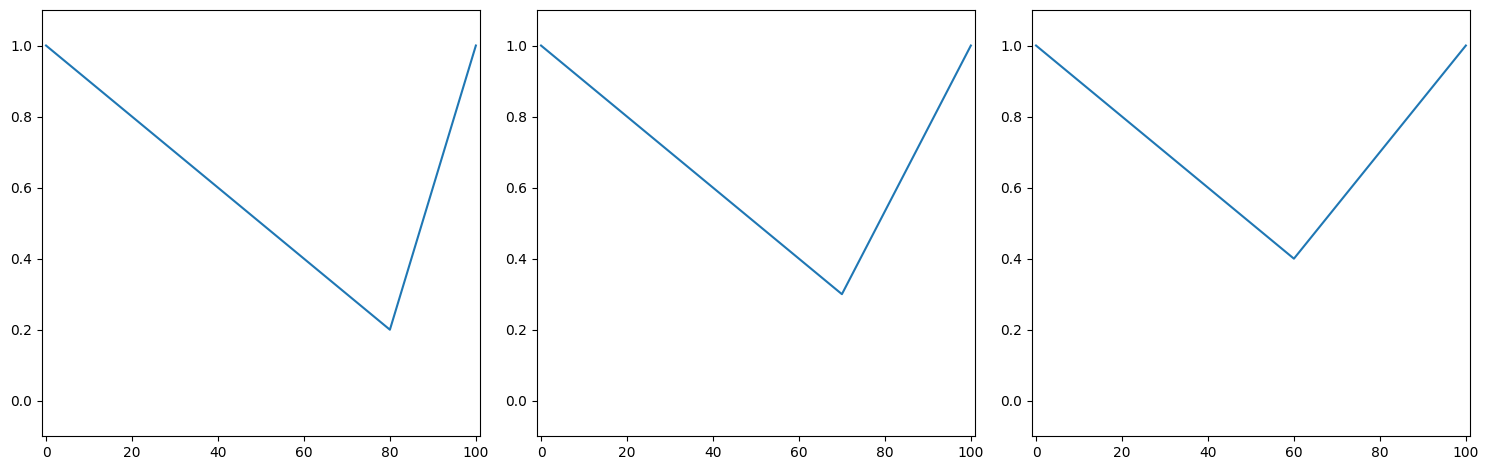

In [325]:
plt.close()
plot_schedules(t, s, "reverse_anneal.jpg")


In [326]:
reverse_samplesets = []
reverse_schedules_for_iter = reverse_schedules
reverse_schedules = []
trials = 10
num_reads = 1000
for schedule in reverse_schedules_for_iter:
    print("annealing start")
    if solver == "QA":
        for i in range(trials):
            reverse_schedules.append(schedule)
            reverse_sample = sampler.sample_qubo(
                Q, num_reads=num_reads, anneal_schedule=schedule, initial_state=init, reinitialize_state=False)
            reverse_samplesets.append(reverse_sample)
            init = reverse_sample.samples()[0]
    else:
        reverse_samplesets.append(sampler.sample_qubo(Q))
    print("annealing end")


annealing start
annealing end
annealing start
annealing end
annealing start
annealing end


#### 結果

In [327]:
reverse_samplesets


[SampleSet(rec.array([([0, 1, 0, 1, 1, 0, 0, 0], -3143., 1, 0.   ),
            ([0, 0, 1, 0, 0, 1, 0, 1], -3132., 1, 0.   ),
            ([0, 0, 0, 0, 1, 1, 0, 1], -2730., 1, 0.   ),
            ([1, 0, 0, 0, 1, 0, 1, 1], -3152., 1, 0.   ),
            ([0, 0, 1, 0, 0, 1, 0, 1], -3132., 1, 0.   ),
            ([0, 1, 0, 0, 1, 0, 1, 1], -3052., 1, 0.   ),
            ([0, 0, 1, 0, 1, 0, 0, 1], -3158., 1, 0.   ),
            ([1, 0, 0, 0, 1, 1, 1, 1], -3048., 1, 0.   ),
            ([0, 1, 0, 0, 1, 1, 0, 1], -3156., 1, 0.   ),
            ([0, 0, 1, 0, 0, 1, 0, 1], -3132., 1, 0.   ),
            ([0, 0, 0, 1, 0, 1, 0, 1], -3055., 1, 0.   ),
            ([1, 1, 0, 0, 0, 0, 1, 0], -3136., 1, 0.   ),
            ([0, 1, 0, 0, 0, 0, 1, 0], -2922., 1, 0.   ),
            ([0, 0, 1, 0, 0, 0, 1, 1], -2924., 1, 0.   ),
            ([1, 1, 0, 0, 0, 1, 0, 1], -3136., 1, 0.   ),
            ([0, 1, 1, 0, 1, 1, 0, 0], -3064., 1, 0.   ),
            ([0, 1, 1, 0, 1, 1, 0, 0], -3064., 1, 0.   ),
    

In [328]:
reverse_samples_info = v_transform_sample(reverse_samplesets, reverse_schedules, model)
v_output_sample_info(reverse_samples_info)


anneal time = 100.0
anneal schedule = [(0, 1), (80.0, 0.2), (100, 1.0)]
---- result -----
opt_count : 27
success rate : 0.027
-----------------
----- best ------
slack_Y = 2
broken: {'HA': (False, 104.0)}
cost : 23.0
weight : 11.0
-----------------
---- average -----
cost : 15.773504273504274
-----------------
----- worst -----
slack_Y = 14
broken: {'HA': (False, 26.0)}
cost : 0.0
weight : 0.0
-----------------
-----describe----
              cost       weight       energy        sol_y
count  1000.000000  1000.000000  1000.000000  1000.000000
mean     16.519000     7.497000 -3085.871000     5.073000
std       6.269206     2.982094   109.425053     3.951618
min       0.000000     0.000000 -3169.000000     0.000000
25%      12.000000     6.000000 -3143.000000     2.000000
50%      16.000000     7.000000 -3132.000000     4.000000
75%      22.000000    10.000000 -3058.000000     8.000000
max      31.000000    15.000000 -2222.000000    15.000000

anneal time = 100.0
anneal schedule = [(0, 1

### 最悪値採用

In [329]:
init = samplesets[0].samples()[-1]

In [330]:
reverse_worst_schedules = deepcopy(reverse_schedules)
reverse_worst_schedules = []
print(reverse_worst_schedules)

[]


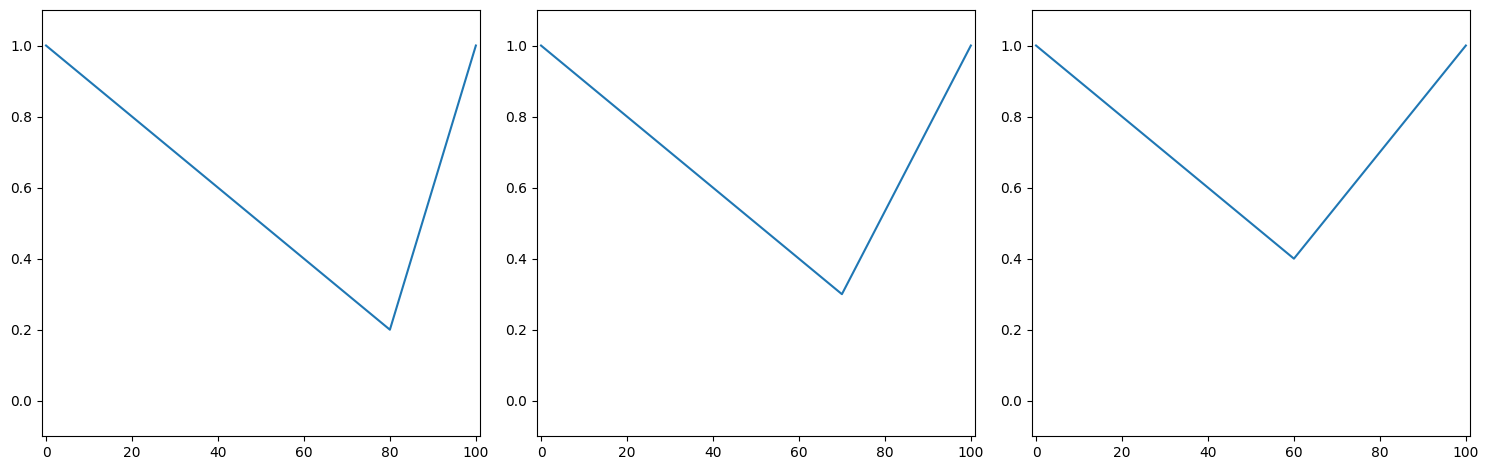

In [331]:
plt.close()
plot_schedules(t, s, "reverse_anneal.jpg")

In [332]:
reverse_worst_samplesets = []
for schedule in reverse_worst_schedules:
    print("annealing start")
    if solver == "QA":
        reverse_worst_samplesets.append(sampler.sample_qubo(
            Q, num_reads=num_reads, anneal_schedule=schedule, initial_state=init, reinitialize_state=True))
    else:
        reverse_worst_samplesets.append(sampler.sample_qubo(Q))
    print("annealing end")


#### 結果

In [333]:
reverse_worst_samples_info = v_transform_sample(
    reverse_worst_samplesets, reverse_worst_schedules, model)
v_output_sample_info(reverse_worst_samplesets)


In [334]:
for info in samples_info:
    print("& FQA", "&",
          info["average_cost"], "&", info["success_rate"], "\\\\")
for info in reverse_samples_info:
    print("& RQA($s_{\\rm{inv}} =", "{}$)".format(info["anneal_schedule"][1][1]), "&",
          info["average_cost"], "&", info["success_rate"], "\\\\")
for info in reverse_worst_samples_info:
    print(info["anneal_schedule"], "&",
          info["average_cost"], "&", info["success_rate"], "\\\\")


& FQA & 13.53921568627451 & 0.007 \\
& RQA($s_{\rm{inv}} = 0.2$) & 15.773504273504274 & 0.027 \\
& RQA($s_{\rm{inv}} = 0.2$) & 15.198689956331878 & 0.024 \\
& RQA($s_{\rm{inv}} = 0.2$) & 15.118995633187772 & 0.032 \\
& RQA($s_{\rm{inv}} = 0.2$) & 14.445523193096008 & 0.043 \\
& RQA($s_{\rm{inv}} = 0.2$) & 14.885496183206106 & 0.03 \\
& RQA($s_{\rm{inv}} = 0.2$) & 14.970297029702971 & 0.029 \\
& RQA($s_{\rm{inv}} = 0.2$) & 14.333685322069694 & 0.044 \\
& RQA($s_{\rm{inv}} = 0.2$) & 14.861259338313767 & 0.031 \\
& RQA($s_{\rm{inv}} = 0.2$) & 15.474945533769063 & 0.021 \\
& RQA($s_{\rm{inv}} = 0.2$) & 15.187839305103148 & 0.024 \\
& RQA($s_{\rm{inv}} = 0.3$) & 15.224534501642935 & 0.027 \\
& RQA($s_{\rm{inv}} = 0.3$) & 14.228540772532188 & 0.036 \\
& RQA($s_{\rm{inv}} = 0.3$) & 15.288604898828542 & 0.028 \\
& RQA($s_{\rm{inv}} = 0.3$) & 15.522340425531915 & 0.019 \\
& RQA($s_{\rm{inv}} = 0.3$) & 14.581296493092454 & 0.032 \\
& RQA($s_{\rm{inv}} = 0.3$) & 14.519618239660657 & 0.034 \\
& RQ

In [335]:
for info in reverse_samples_info:
    print(info.keys())
    print()

dict_keys(['anneal_time', 'anneal_schedule', 'info_sets', 'best_value', 'average_cost', 'worst_value', 'dataframe', 'opt_count', 'success_rate'])

dict_keys(['anneal_time', 'anneal_schedule', 'info_sets', 'best_value', 'average_cost', 'worst_value', 'dataframe', 'opt_count', 'success_rate'])

dict_keys(['anneal_time', 'anneal_schedule', 'info_sets', 'best_value', 'average_cost', 'worst_value', 'dataframe', 'opt_count', 'success_rate'])

dict_keys(['anneal_time', 'anneal_schedule', 'info_sets', 'best_value', 'average_cost', 'worst_value', 'dataframe', 'opt_count', 'success_rate'])

dict_keys(['anneal_time', 'anneal_schedule', 'info_sets', 'best_value', 'average_cost', 'worst_value', 'dataframe', 'opt_count', 'success_rate'])

dict_keys(['anneal_time', 'anneal_schedule', 'info_sets', 'best_value', 'average_cost', 'worst_value', 'dataframe', 'opt_count', 'success_rate'])

dict_keys(['anneal_time', 'anneal_schedule', 'info_sets', 'best_value', 'average_cost', 'worst_value', 'dataframe', 'o

IndexError: list index out of range

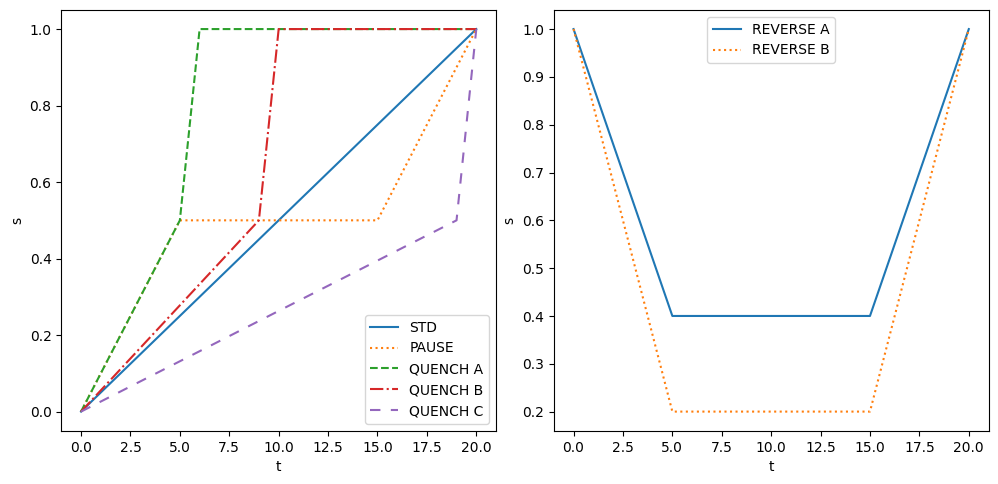

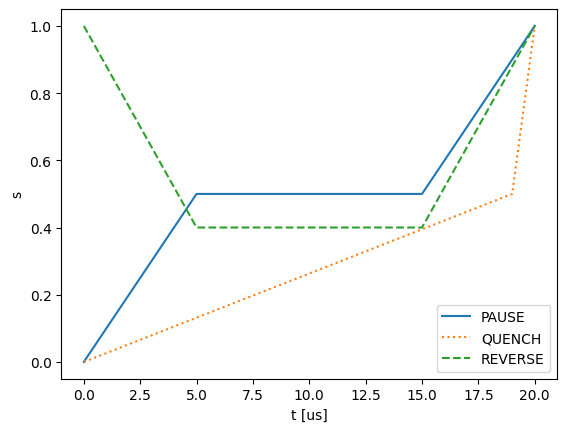

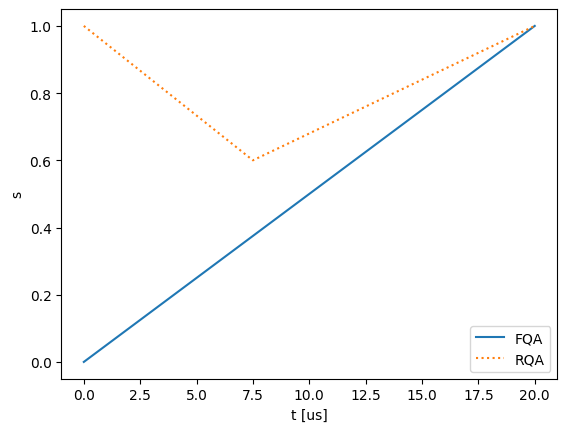

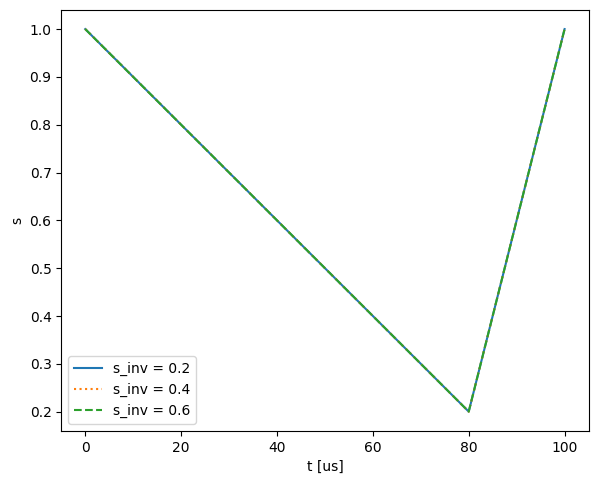

In [336]:
t = [(0, 20), (0, 5, 15, 20), (0, 5, 6, 20), (0, 9, 10, 20), (0, 19, 20)]
s = [(0, 1), (0, 0.5, 0.5, 1), (0, 0.5, 1, 1), (0, 0.5, 1, 1), (0, 0.5, 1)]
t2 = [(0, 5, 15, 20), (0, 5, 15, 20)]
s2 = [(1.0, 0.4, 0.4, 1.0), (1, 0.2, 0.2, 1.0)]
t_set = [t, t2]
s_set = [s, s2]
label = [["STD", "PAUSE", "QUENCH A", "QUENCH B",
          "QUENCH C"], ["REVERSE A", "REVERSE B"]]
linestyle = ["solid", "dotted", "dashed",
             "dashdot",  (0, (5, 5)), (0, (3, 1, 1, 1))]

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.tight_layout()

for i in range(2):
    for j in range(len(t_set[i])):
        ax[i].plot(t_set[i][j], s_set[i][j], label=label[i]
                   [j], linestyle=linestyle[j])

        ax[i].set_xlabel("t")
        ax[i].set_ylabel("s")
        ax[i].legend(loc=0)
plt.savefig("fixed-anneal_schedule.jpg")


t = [ (0, 5, 15, 20), (0, 19, 20), (0, 5, 15, 20)]
s = [ (0, 0.5, 0.5, 1),  (0, 0.5, 1), (1.0, 0.4, 0.4, 1.0)]
label = ["PAUSE", "QUENCH", "REVERSE"]
fig, ax = plt.subplots()

for i in range(len(t)):
    ax.plot(t[i], s[i], label=label[i], linestyle=linestyle[i])
    ax.set_xlabel("t [us]")
    ax.set_ylabel("s")
    ax.legend(loc=0)

plt.savefig("fixed-example_schedules.jpg")

t = [ (0, 20), (0, 7.5, 20)]
s = [ (0, 1),  (1, 0.6, 1)]
label = ["FQA", "RQA"]
fig, ax = plt.subplots()

for i in range(len(t)):
    ax.plot(t[i], s[i], label=label[i], linestyle=linestyle[i])
    ax.set_xlabel("t [us]")
    ax.set_ylabel("s")
    ax.legend(loc=0)

plt.savefig("example_schedules-fqa-rqa.jpg")

fig, ax = plt.subplots()
label = ["s_inv = 0.2", "s_inv = 0.4", "s_inv = 0.6"]
fig.set_figwidth(6)
fig.tight_layout()
for i, schedule in enumerate(reverse_schedules):
    t = []
    s = []
    for tmp_t, tmp_s in schedule:
        t.append(tmp_t)
        s.append(tmp_s)
        
    ax.plot(t, s, label=label[i], linestyle=linestyle[i])
    ax.set_xlabel("t [us]")
    ax.set_ylabel("s")
    ax.legend(loc=0)
    
plt.savefig("reverse_schedules.jpg")

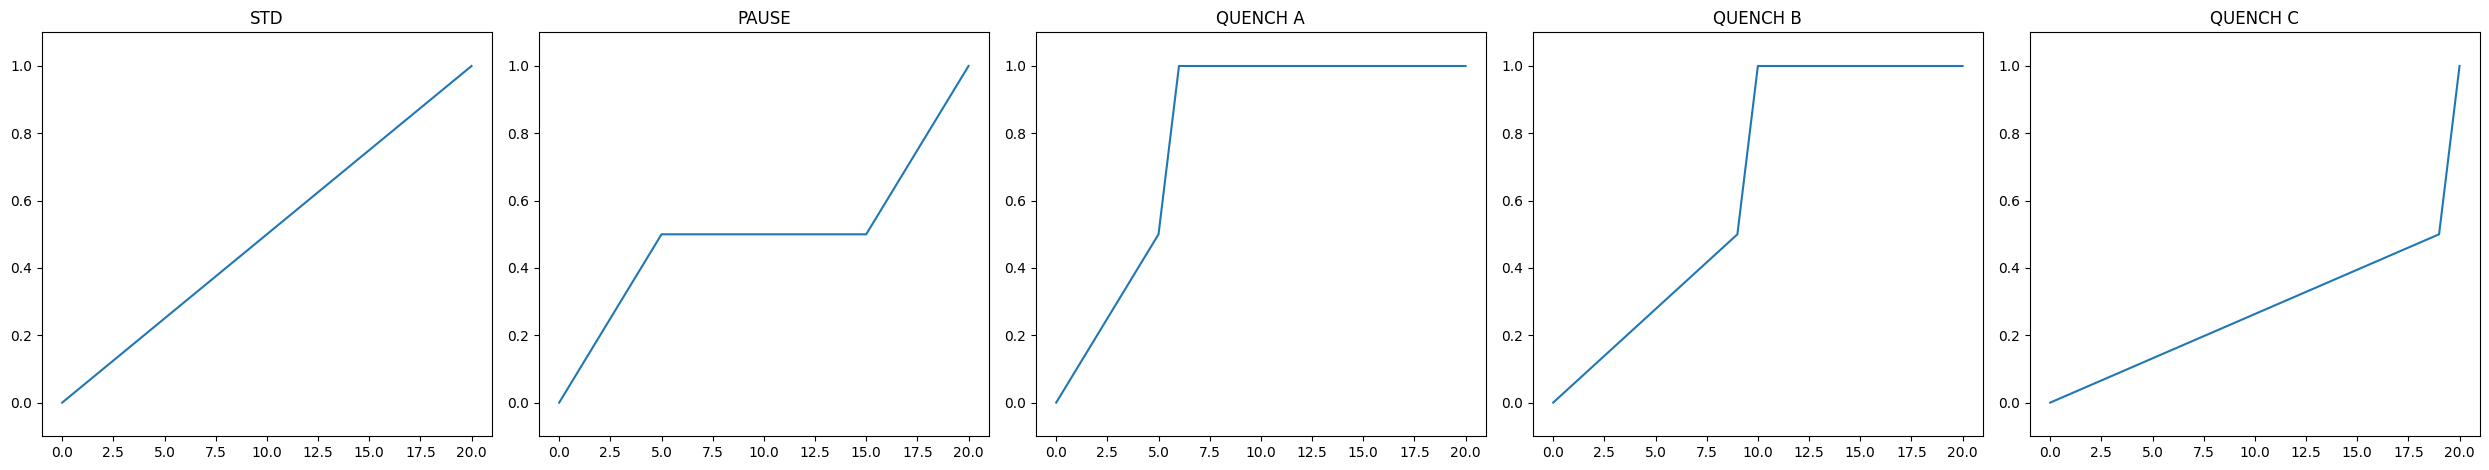

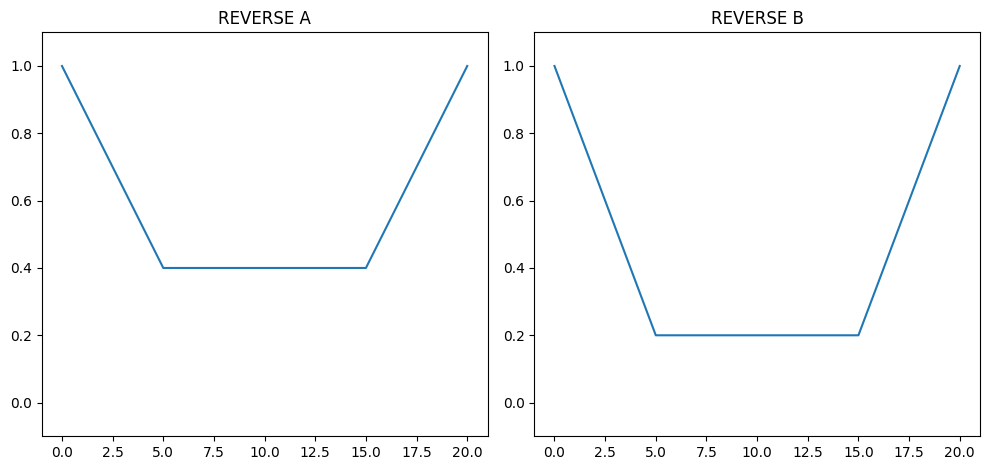

In [ ]:
t = [(0, 20), (0, 5, 15, 20), (0, 5, 6, 20), (0, 9, 10, 20), (0, 19, 20)]
s = [(0, 1), (0, 0.5, 0.5, 1), (0, 0.5, 1, 1), (0, 0.5, 1, 1), (0, 0.5, 1)]
plot_schedules(t, s, "pause_quench_schedule.jpg", [
               "std", "pause", "quench A", "quench B", "quench C"])

t = [(0, 5, 15, 20), (0, 5, 15, 20)]
s = [(1.0, 0.4, 0.4, 1.0), (1, 0.2, 0.2, 1.0)]
plot_schedules(t, s, "reverse_anneal.jpg", [
               "reverse A", "reverse B"]) 


TypeError: 'AxesSubplot' object is not subscriptable

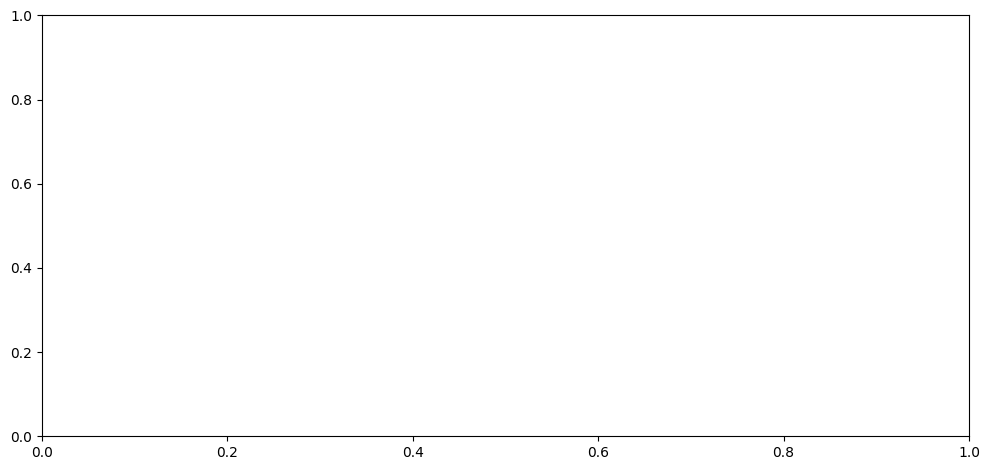

In [ ]:
s = [(0, 1), (0,1)]
y = [(0, 1), (1,0)]

label = ["A(s)","B(s)"]
linestyle = ["solid", "dotted", "dashed",
             "dashdot",  (0, (5, 5)), (0, (3, 1, 1, 1))]

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.tight_layout()

for i in range(2):
    for j in range(len(t_set[i])):
        ax[i].plot(t_set[i][j], s_set[i][j], label=label[i]
                   [j], linestyle=linestyle[j])

        ax[i].set_xlabel("t")
        ax[i].set_ylabel("s")
        ax[i].legend(loc=0)
plt.savefig("fn-A-B")


